In [186]:
import itertools
from abc import ABCMeta, abstractmethod, abstractproperty
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import scipy.stats
from sklearn.base import ClassifierMixin, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, OneClassSVM
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix
from copy import copy, deepcopy
from progressbar import ProgressBar
from tabulate import tabulate

# Naive Bayes

In [14]:
df_train = pd.read_csv('default_train.csv')
df_test = pd.read_csv('default_test.csv')
df_train['student'] = np.where(
    df_train['student'] == 'Yes', 1, 0)
df_test['student'] = np.where(
    df_test['student'] == 'Yes', 1, 0)
X_train = df_train.iloc[:,1:].values
y_train = np.where(df_train['default'] == 'Yes', 1, 0)
X_test = df_test.iloc[:,1:].values
y_test = np.where(df_test['default'] == 'Yes', 1, 0)
X_names = list(df_train.columns)[1:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6000, 3) (4000, 3)
(6000,) (4000,)


## Exploratory Data Analysis

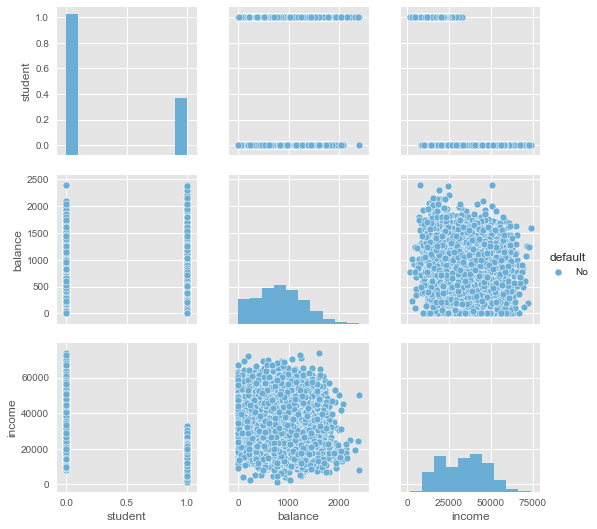

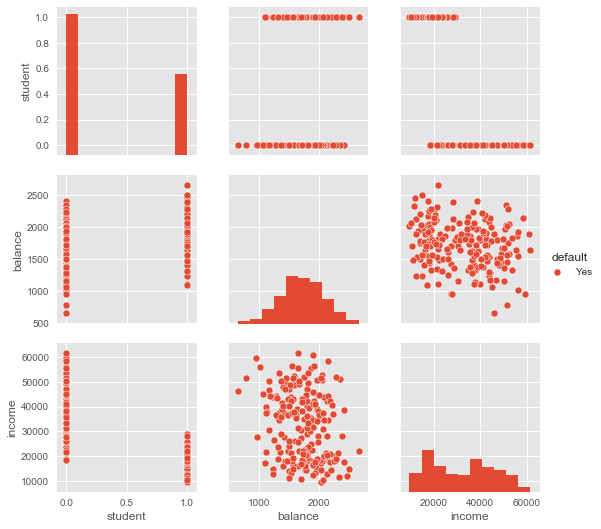

In [50]:
sns.pairplot(
    df_train[df_train['default'] == 'No'], 
    hue='default',palette="Blues")
sns.pairplot(
    df_train[df_train['default'] == 'Yes'], 
    hue='default')

For both classes, `balance` and `income` seem to be independent, but `student` and `income` are clearly correlated: students tend to have lower income. Moreover, for `default = 1` class, `balance` and `student` tend to be correlated as well. So we doubt the assumption of the Naive Bayes model. 

## Fit the Naive Bayes Model

In [154]:
class Marginal:
    __metaclass__ = ABCMeta
    @abstractmethod
    def estimate(self, sample):
        raise NotImplementedError
    
    @abstractmethod
    def log_likelihood(self, x):
        raise NotImplementedError
        
class BernoulliMarginal(Marginal):
    def __init__(self):
        self.p = None
        
    def __repr__(self):
        return "Bernoulli({})".format(self.p)
    
    def estimate(self, sample):
        self.p = np.sum(sample)/len(sample)
        
    def log_likelihood(self, x):
        return np.log(self.p)*x + np.log(
            1-self.p)*(1-x)
    
class GaussianMarginal(Marginal):
    def __init__(self):
        self.mu = None
        self.sigma_sq = None
        
    def __repr__(self):
        return "Gaussian({}, {})".format(
            self.mu, self.sigma_sq)
    
    def estimate(self, sample):
        self.mu = np.average(sample)
        self.sigma_sq = np.sum([
            (x-self.mu)**2 for x in sample])/len(sample)
        
    def log_likelihood(self, x):
        return -0.5*np.log(
            2*np.pi*self.sigma_sq) - (
            x-self.mu)**2/(2*self.sigma_sq)

class AwesomeNaiveBayes(ClassifierMixin, BaseEstimator, TransformerMixin):
    
    def __init__(self, marginals, n_cls, x_names=None):
        self.n_cls = n_cls
        self.marginals = {
            l: deepcopy(marginals) for l in range(n_cls)}
        self.d = len(marginals)
        self.priors = {l: None for l in range(n_cls)}
        self.x_names = x_names
        if not x_names:
            self.x_names = ['X'+str(i) for i in range(self.d)]
        self.fitted = False
    
    def __repr__(self):
        _repr, rows = 'NaiveBayesClassifier()\n', []
        if not self.fitted:
            return _repr
        for k in range(self.n_cls):
            rows.append(
                ['log P(Y={})'.format(k), self.priors[k]])
            for i, s in enumerate(self.x_names):
                rows.append([
                    s+'|Y={}'.format(k),
                    str(self.marginals[k][i])])
        _repr += tabulate(
            rows, headers=['', 'Estimate'])
        return _repr
        
    def fit(self, X_train, y_train):
        n, d = X_train.shape
        y_cls = np.unique(y_train)
        assert len(y_cls) == self.n_cls
        assert d == len(self.marginals[0])     
        for k in range(self.n_cls):
            for j in range(d):
                self.marginals[k][j].estimate(
                    X_train[y_train == k, j])
            self.priors[k] = np.log(
                np.sum(y_train == k)/n)
        self.fitted = True
        return self
    
    def predict(self, X_test):
        log_proba = self.predict_log_proba(X_test)
        return np.argmax(log_proba, 1)
    
    def predict_log_proba(self, X_test):
        pred = np.zeros((len(X_test), self.n_cls))
        for i, row in enumerate(X_test):
            for k in range(self.n_cls):
                pred[i,k] = self.priors[k]
                for j, marginal in enumerate(self.marginals[k]):
                    pred[i,k] += marginal.log_likelihood(row[j])
        return pred    

In [155]:
clf = AwesomeNaiveBayes(
    [BernoulliMarginal(), GaussianMarginal(), GaussianMarginal()], 
    2, ['student', 'balance', 'income'])
clf.fit(X_train, y_train)
# the parameter estimates are reported as the class representation
# in the output box below.

NaiveBayesClassifier()
             Estimate
-----------  ------------------------------------------------
log P(Y=0)   -0.03338444401958382
student|Y=0  Bernoulli(0.28847148026882646)
balance|Y=0  Gaussian(806.4452220460979, 206827.67007859287)
income|Y=0   Gaussian(33451.15029361857, 177429727.3217092)
log P(Y=1)   -3.4163110194722037
student|Y=1  Bernoulli(0.36548223350253806)
balance|Y=1  Gaussian(1718.8534899175334, 127084.50907211454)
income|Y=1   Gaussian(32128.86080803881, 184822064.0125683)

## Prediction and Model Evaluation

In [156]:
y_pred = clf.predict(X_test)
l = clf.predict_log_proba(X_test)
score = l[:,1] - l[:,0]

misclf_rate = 1-accuracy_score(
    y_test, y_pred, normalize=1)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, score)
print(
"""
The misclassification rate is: {},
The confusion matrix: \n {}
""".format(misclf_rate, cm)
)


The misclassification rate is: 0.028249999999999997, 

The confusion matrix: 
 [[3851   13]
 [ 100   36]]



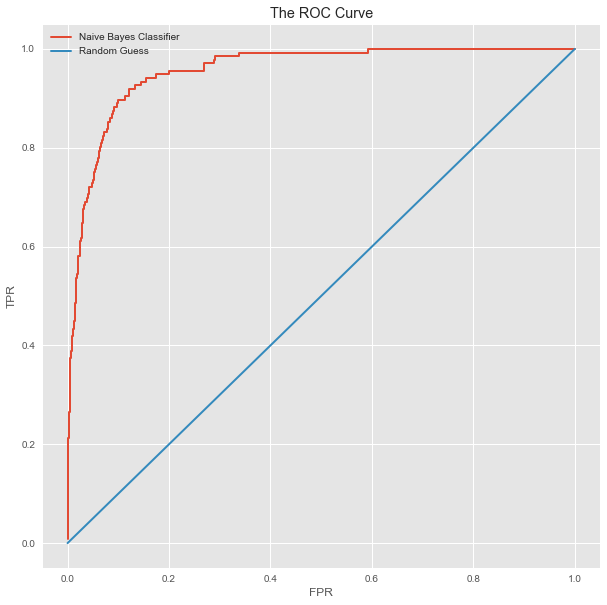

In [157]:
# ROC curve
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(fpr, tpr, linewidth=2,
        label='Naive Bayes Classifier')
ax.plot([0,1], [0,1], linewidth=2,
        label='Random Guess')
ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})
_ = ax.legend()

# Class Weights

In [162]:
from mlxtend.plotting import plot_decision_regions

In [161]:
def get_data(n1,n2):
    dist1 = scipy.stats.multivariate_normal(
        mean = np.zeros(2), cov = np.diag(np.ones(2)))
    dist2 = scipy.stats.multivariate_normal(
        mean = np.ones(2), cov = np.diag(np.ones(2)))
    X = np.concatenate(
        [dist1.rvs(size=n1), dist2.rvs(size=n2)], axis=0)
    y = np.array([0]*n1 + [1]*n2)
    return(X,y)

## Linear SVM on Training Set

In [180]:
X_train, y_train = get_data(500, 100)
svc_clf = SVC(C=1)
svc_clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

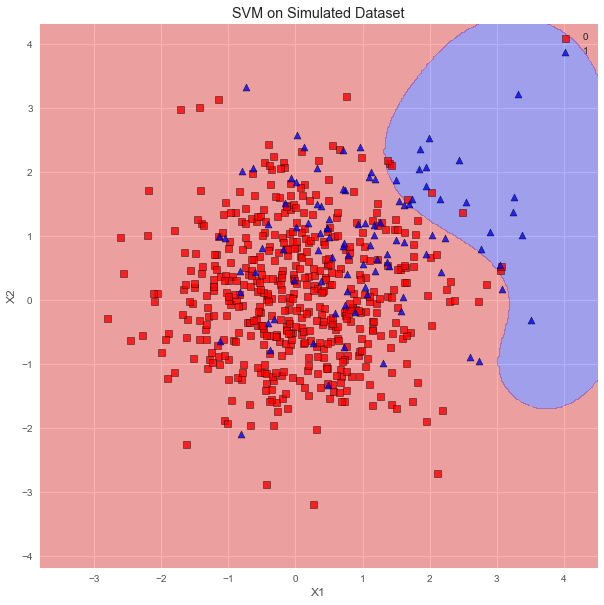

In [181]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X_train, y_train, clf=svc_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'SVM on Simulated Dataset'})

## Prediction on Testset

In [184]:
X_test, y_test = get_data(500, 500)
y_pred = svc_clf.predict(X_test)

misclf_rate = 1-accuracy_score(
    y_test, y_pred, normalize=1)
cm = confusion_matrix(y_test, y_pred)
print(
"""
The misclassification rate is: {},
The confusion matrix: \n {}
""".format(misclf_rate, cm)
)


The misclassification rate is: 0.42100000000000004,
The confusion matrix: 
 [[499   1]
 [420  80]]



The strange thing is that the False Negative is a lot more than the False positive, which implies that the classifier is too conservative on making positive prediction. And the misclassifaction rate is also very high.

The reason why we get such a weird result in a balanced problem is we trained with an imbalanced dataset, and assign equal weights to both classes. The classifier therefore thinks that the positive sample is much less than the negative samples in general, which is not the case in the test set. Consequently, it made too conservative prediction on the positive points.

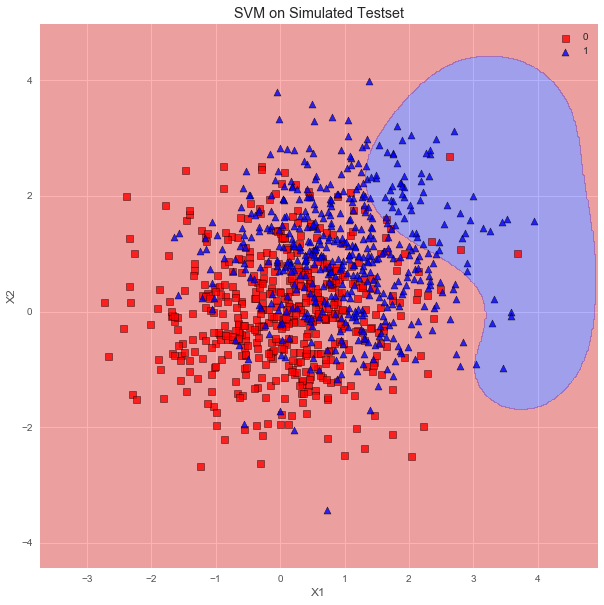

In [183]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X_test, y_test, clf=svc_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'SVM on Simulated Testset'})

## Refit SVC

In [185]:
svc_clf_bal = SVC(C=1, class_weight='balanced')
svc_clf_bal.fit(X_train, y_train)
y_pred_2 = svc_clf_bal.predict(X_test)

misclf_rate = 1-accuracy_score(
    y_test, y_pred_2, normalize=1)
cm = confusion_matrix(y_test, y_pred_2)
print(
"""
The misclassification rate is: {}, 
The confusion matrix: \n {}
""".format(misclf_rate, cm)
)


The misclassification rate is: 0.255, 
The confusion matrix: 
 [[382 118]
 [137 363]]



We can see that the classifier can make balanced predictions this time. The misclassification rate is lower, and we have a very balanced confusion matrix, with approximately the same number of FP and FNs.

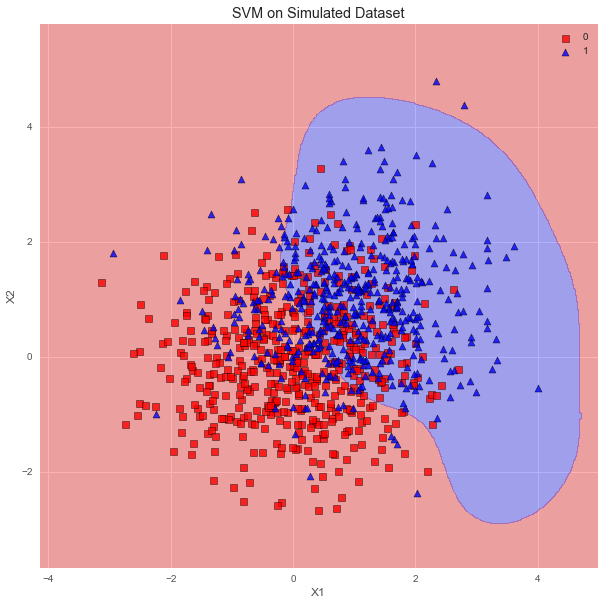

In [179]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X_test, y_test, clf=svc_clf_bal)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'SVM on Simulated Dataset'})

# Anomaly Detection

In [187]:
def get_data_anomaly(n):
    #prior probabilities
    pi0 = (.5,.3,.2)
    n_each = [int(n*pi) for pi in pi0]
    #means
    mus = ((0,0),(2,4),(-4,2))
    Sigmas = [
        np.matrix(((1,-0.7),(-0.7,0.9)))*1.6,
        np.matrix(((1,0.8),(0.8,0.9)))*1.6,
        np.matrix(((1,0.8),(0.8,0.9)))*1.6
    ]
    gaussians = [scipy.stats.multivariate_normal(
        mean = mus[i],cov = Sigmas[i]) for i in range(3)]
    X = np.concatenate([
        gaussian.rvs(n_each[i]) 
        for i, gaussian in enumerate(gaussians)], axis=0)    
    return(X)


## Exploratory Data Analysis 

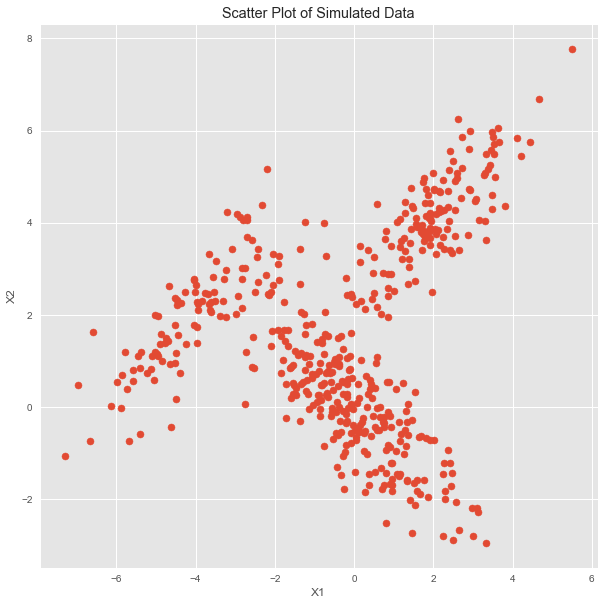

In [191]:
X = get_data_anomaly(500)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(X[:,0], X[:,1])
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'Scatter Plot of Simulated Data'})

## One-class SVM

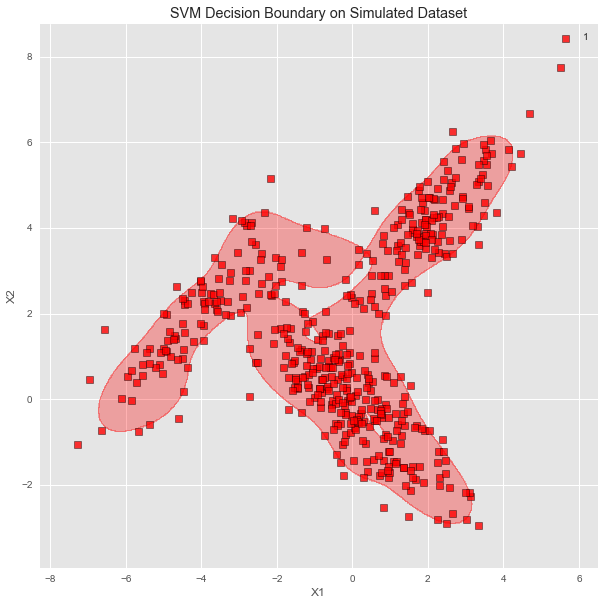

In [199]:
ocs_clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X,np.ones(500,dtype=int), clf=ocs_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'SVM Decision Boundary on Simulated Dataset'})

## Meaning of $\gamma$

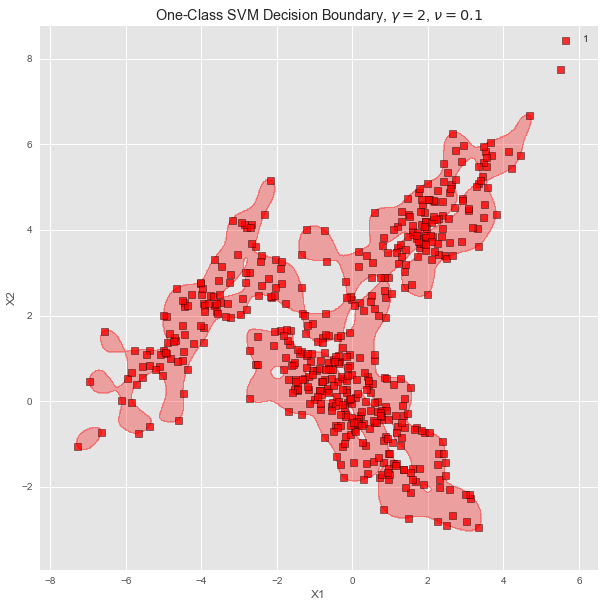

In [200]:
ocs_clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=2)
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X,np.ones(500,dtype=int), clf=ocs_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'One-Class SVM Decision Boundary,'+
               r' $\gamma={}$, $\nu={}$'.format(2, 0.1)})

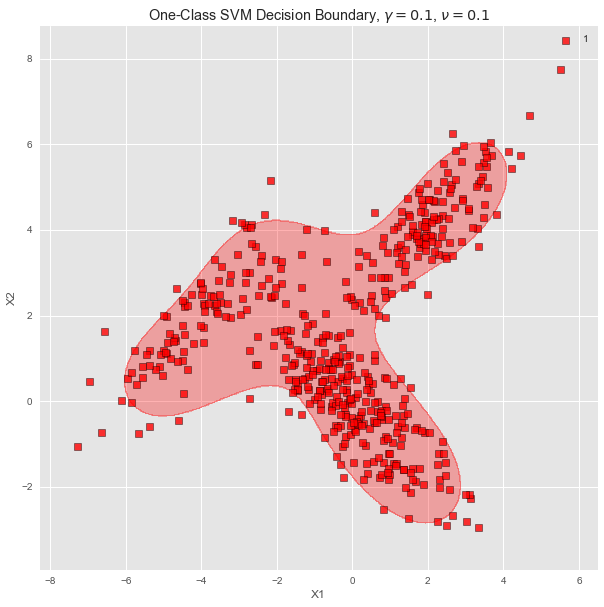

In [201]:
ocs_clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X,np.ones(500,dtype=int), clf=ocs_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'One-Class SVM Decision Boundary,'+
               r' $\gamma={}$, $\nu={}$'.format(0.1, 0.1)})

$\gamma$ seems to affect the shape of the decision boundary. Larger $\gamma$ results in a more complex shape of the boundary, and each sample point tends to affect a smaller local region. Smaller $\gamma$ results in a smoother boundary, which appears to be the average of more sample points' influence, in other words, each sample point affects a bigger region.

## Meaning of $\nu$

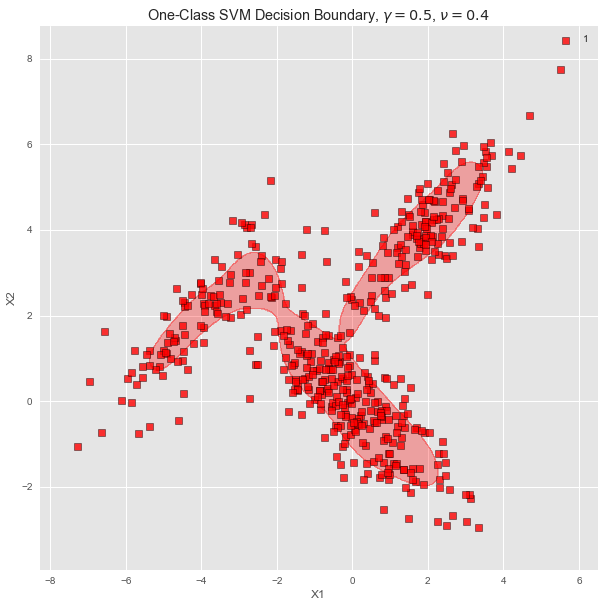

In [202]:
ocs_clf = OneClassSVM(nu=0.4, kernel="rbf", gamma=0.5)
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X,np.ones(500,dtype=int), clf=ocs_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'One-Class SVM Decision Boundary,'+
               r' $\gamma={}$, $\nu={}$'.format(0.5, 0.4)})

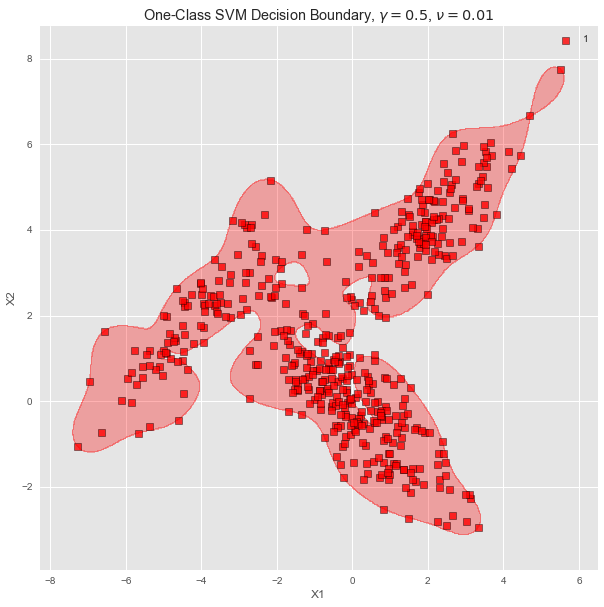

In [203]:
ocs_clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.5)
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_decision_regions(X,np.ones(500,dtype=int), clf=ocs_clf)
_ = ax.update({'xlabel':'X1', 'ylabel':'X2', 
               'title':'One-Class SVM Decision Boundary,'+
               r' $\gamma={}$, $\nu={}$'.format(0.5, 0.01)})

$\nu$ seems to control the tolerance to training error, which is similar to the role of $C$. If $\nu$ is small, the training error is low, more sample points are included in the decision region. Otherwise if $\nu$ is large, the training error is higher.

## DJIA Anomalies

In [227]:
djia = pd.read_csv('DJIA_transformed.csv', header=None)
djia.columns = ['time', 'x1', 'x2', 'x3', 'x4']
X_full = djia.iloc[:,1:]
t_full = djia.iloc[:,0]
X_train, X_test = djia.iloc[:467,1:], djia.iloc[467:,1:]
t_train, t_test = djia.iloc[:467,0], djia.iloc[467:,0]

In [228]:
ocs_clf_djia = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.0000001)
ocs_clf_djia.fit(X_train)
y_pred = ocs_clf_djia.predict(X_full)

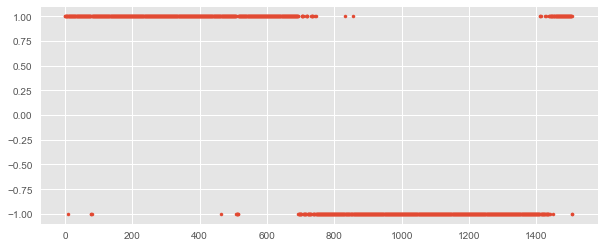

In [229]:
ocs_clf.fit(X)
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(y_pred, '.')

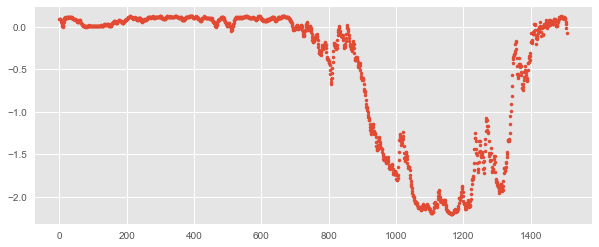

In [230]:
dist_pred = ocs_clf_djia.decision_function(X_full)
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(dist_pred, '.')

In [257]:
# extract the points with scores < -2
anomaly = djia['time'].iloc[(dist_pred < -2.0).reshape(1,len(djia))[0]]
anomaly.iloc[0], anomaly.iloc[-1]

('2007-05-02', '2008-01-03')

The resulting anomalous points with most negative scores are those between 2007-05-02 and 2008-01-03, during the financial crysis, as expected.